Import Libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import joblib


Import stock price history dataset

In [43]:
# Load Tesla dataset
df = pd.read_csv("Tesla_Stock_2010_2024.csv") 
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


Clean and Processed Data

In [44]:
# Handle missing values
df = df.dropna()

In [45]:
# Convert date column
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [46]:

# Keep only 'Close' column for prediction
data = df[['Close']]

Normalize Data

In [47]:

# Normalize values for ML model
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

Calculate Moving Averages

In [48]:
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()

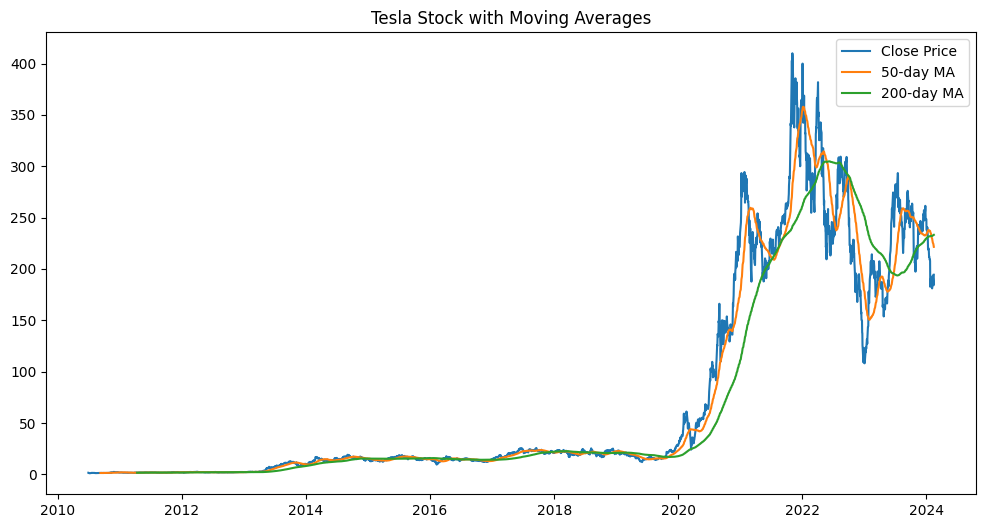

In [49]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label="Close Price")
plt.plot(df['MA50'], label="50-day MA")
plt.plot(df['MA200'], label="200-day MA")
plt.legend()
plt.title("Tesla Stock with Moving Averages")
plt.show()

Calculate Volatility

In [50]:
# Volatility (30-day rolling standard deviation)
df['Volatility'] = df['Close'].rolling(window=30).std()

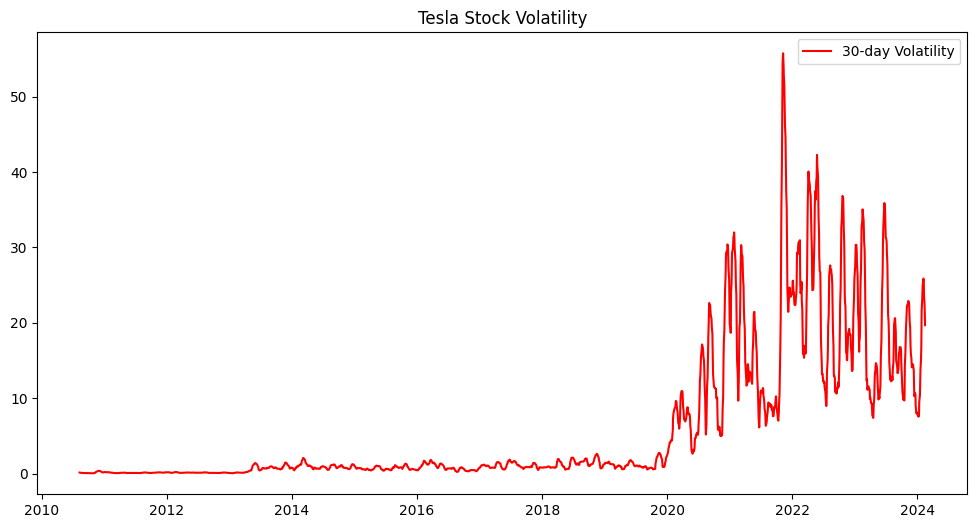

In [51]:
plt.figure(figsize=(12,6))
plt.plot(df['Volatility'], label="30-day Volatility", color="red")
plt.legend()
plt.title("Tesla Stock Volatility")
plt.show()

Applying ML Model for Short-Term Prediction

In [52]:
# Sequence creation
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

In [53]:
time_step = 60
X, y = create_sequences(scaled_data, time_step)

In [54]:
# Reshape for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

In [55]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [56]:
# Build LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
# Train
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 7.6475e-04
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2.1360e-04
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.7199e-04
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.8575e-04
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.9354e-04
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 1.2921e-04
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.1025e-04
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.5292e-04
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.3026e-04
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.1396e-04


Predict Short-Term Prices

In [58]:
# Predictions
y_pred = model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [59]:
# Convert back to real prices
y_pred = scaler.inverse_transform(y_pred)
y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))

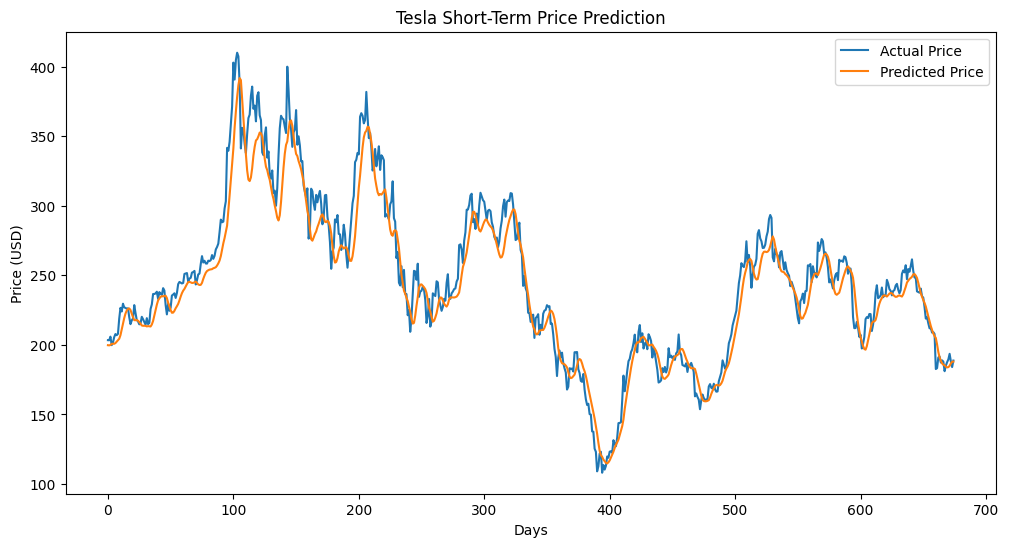

In [60]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label="Actual Price")
plt.plot(y_pred, label="Predicted Price")
plt.title("Tesla Short-Term Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

Save Model

In [61]:
# Save model + scaler
model.save("tesla_stock_model.h5")
joblib.dump(scaler, "tesla_scaler.pkl")

['tesla_scaler.pkl']

Other models for Comparison

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import pickle

Helper functions for Metrics

In [63]:
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Model": model_name, "RMSE": rmse, "MAE": mae, "MAPE": mape}

Preparing dataset for classical ML (use Close values directly)

In [64]:
df_ml = df[['Close']].copy()
df_ml['Target'] = df_ml['Close'].shift(-1)   # predict next day's price
df_ml.dropna(inplace=True)

X = df_ml[['Close']].values
y = df_ml['Target'].values

Split Train

In [65]:
split_idx = int(len(X) * 0.8)
X_train_ml, X_test_ml = X[:split_idx], X[split_idx:]
y_train_ml, y_test_ml = y[:split_idx], y[split_idx:]

1. Linear Regression

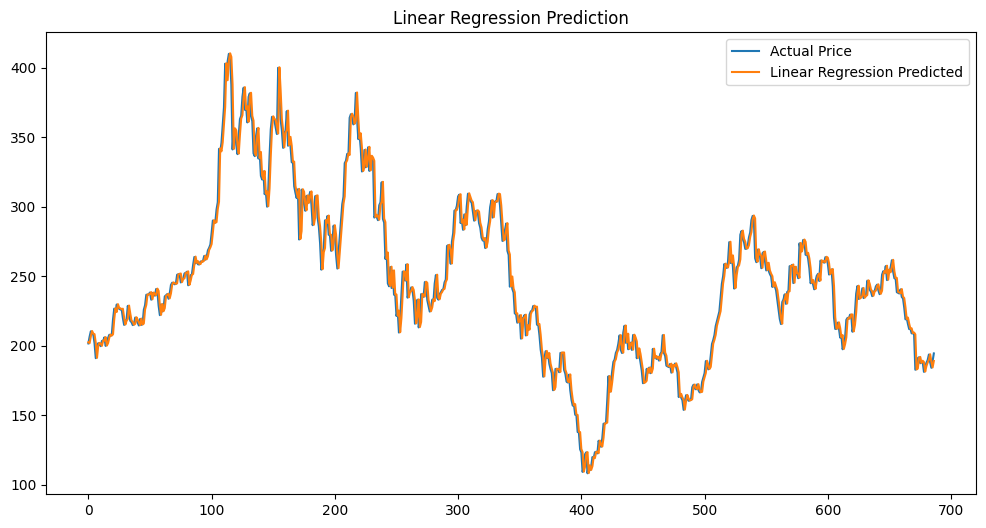

In [66]:
lr = LinearRegression()
lr.fit(X_train_ml, y_train_ml)
lr_preds = lr.predict(X_test_ml)

plt.figure(figsize=(12,6))
plt.plot(y_test_ml, label="Actual Price")
plt.plot(lr_preds, label="Linear Regression Predicted")
plt.legend()
plt.title("Linear Regression Prediction")
plt.show()

lr_metrics = calculate_metrics(y_test_ml, lr_preds, "Linear Regression")

2. Random Forest Regressor

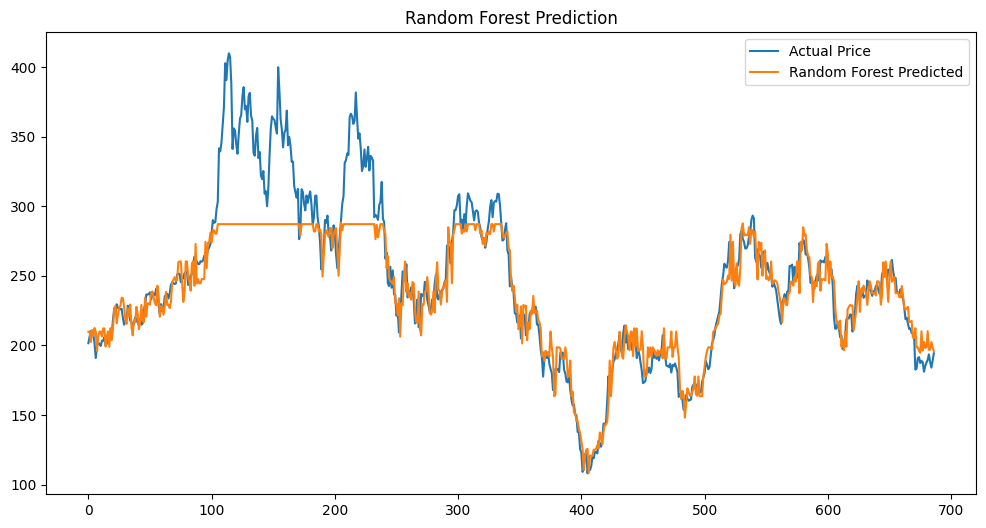

In [67]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train_ml)
rf_preds = rf.predict(X_test_ml)

plt.figure(figsize=(12,6))
plt.plot(y_test_ml, label="Actual Price")
plt.plot(rf_preds, label="Random Forest Predicted")
plt.legend()
plt.title("Random Forest Prediction")
plt.show()

rf_metrics = calculate_metrics(y_test_ml, rf_preds, "Random Forest")

3. Arima

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is availab

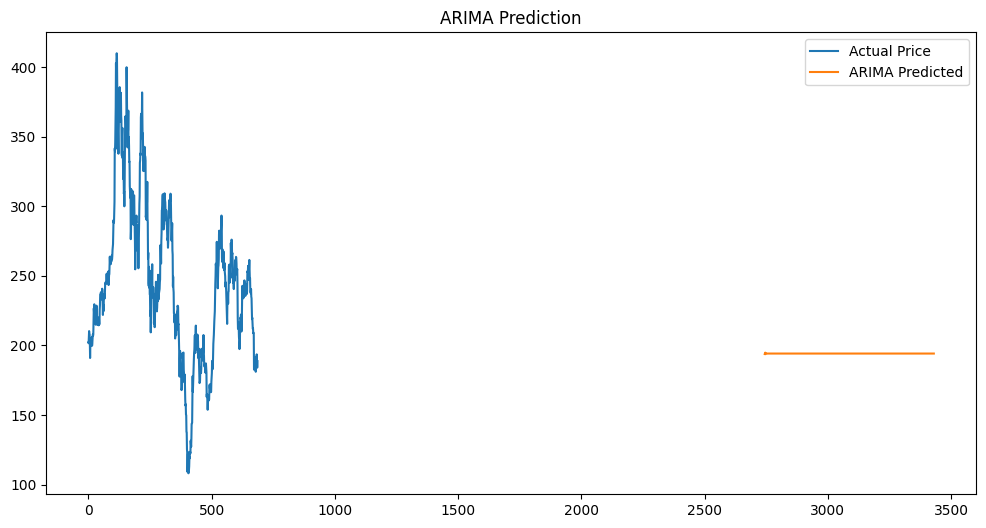

In [68]:
# Use only 'Close' series for ARIMA
train_arima = df_ml['Close'][:split_idx]
test_arima = df_ml['Close'][split_idx:]

# Train ARIMA
arima_model = ARIMA(train_arima, order=(5,1,0))
arima_fit = arima_model.fit()
arima_preds = arima_fit.forecast(steps=len(test_arima))

plt.figure(figsize=(12,6))
plt.plot(test_arima.values, label="Actual Price")
plt.plot(arima_preds, label="ARIMA Predicted")
plt.legend()
plt.title("ARIMA Prediction")
plt.show()

arima_metrics = calculate_metrics(test_arima.values, arima_preds, "ARIMA")


4. XGBoost Regressor

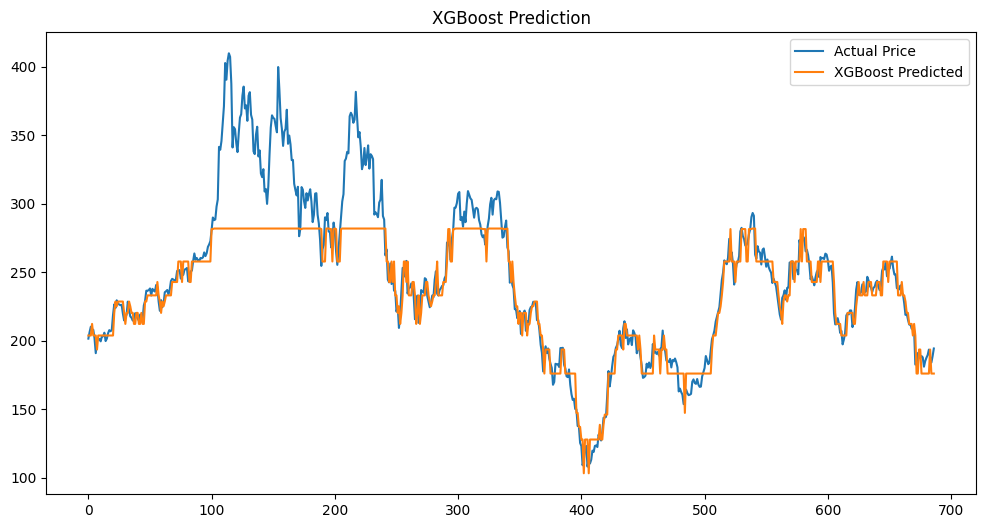

In [69]:
from xgboost import XGBRegressor

# Train XGBoost
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train_ml, y_train_ml)

# Predictions
xgb_preds = xgb.predict(X_test_ml)

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_ml, label="Actual Price")
plt.plot(xgb_preds, label="XGBoost Predicted")
plt.legend()
plt.title("XGBoost Prediction")
plt.show()

# Metrics
xgb_metrics = calculate_metrics(y_test_ml, xgb_preds, "XGBoost")

Compare All Models

In [71]:
metrics_list = [lr_metrics, rf_metrics, arima_metrics, xgb_metrics]

Add LSTM metrics again

In [72]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
lstm_mae = mean_absolute_error(y_test_real, y_pred)
lstm_mape = np.mean(np.abs((y_test_real - y_pred) / y_test_real)) * 100
metrics_list.append({"Model": "LSTM", "RMSE": lstm_rmse, "MAE": lstm_mae, "MAPE": lstm_mape})

Save metrics

In [76]:
import pickle

# Save updated metrics for Streamlit
with open("metrics.pkl", "wb") as f:
    pickle.dump(metrics_list, f)

Saving other models

In [81]:
import joblib
import pickle

# -----------------------------
# 1️⃣ Classical ML models
# -----------------------------
joblib.dump(lr, "linear_regression.pkl")      # Linear Regression
joblib.dump(rf, "random_forest.pkl")         # Random Forest
joblib.dump(xgb, "xgboost.pkl")              # XGBoost

# -----------------------------
# 2️⃣ ARIMA model
# -----------------------------
# Make sure this is the fitted ARIMA model (arima_fit)
with open("arima_model.pkl", "wb") as f:
    pickle.dump(arima_fit, f)

# -----------------------------
# 3️⃣ LSTM model
# -----------------------------
model.save("tesla_stock_model.h5")           # Keras LSTM model

# -----------------------------
# 4️⃣ Scaler
# -----------------------------
joblib.dump(scaler, "tesla_scaler.pkl")      # MinMaxScaler used for LSTM

# -----------------------------
# 5️⃣ Metrics
# -----------------------------
with open("metrics.pkl", "wb") as f:
    pickle.dump(metrics_list, f)             # Save all metrics


In [82]:
# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

               Model       RMSE        MAE       MAPE
0  Linear Regression   9.221124   6.534057   2.663386
1      Random Forest  26.651302  16.148264   5.809112
2              ARIMA  77.639570  61.282772  22.956957
3            XGBoost  27.959793  16.048608   5.656458
4               LSTM  15.848750  11.631289   4.564339


Visualization of Metrics

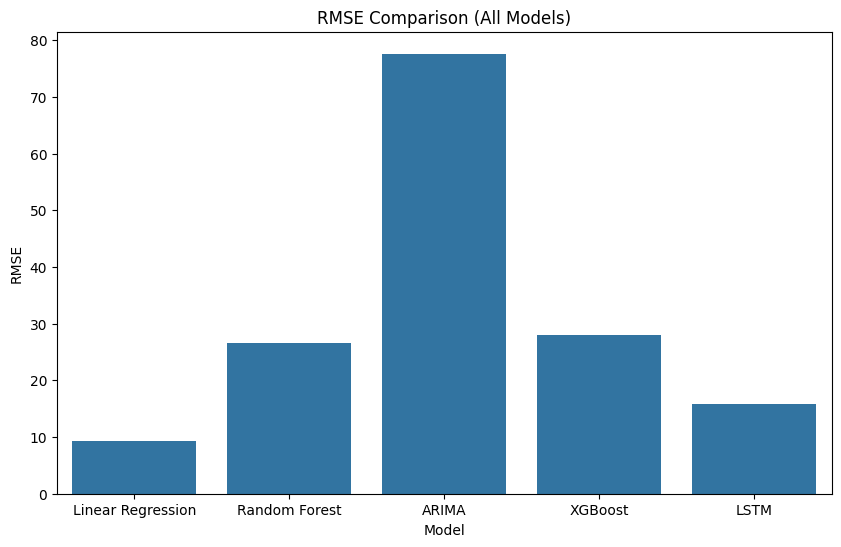

In [83]:
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="RMSE", data=metrics_df)
plt.title("RMSE Comparison (All Models)")
plt.show()

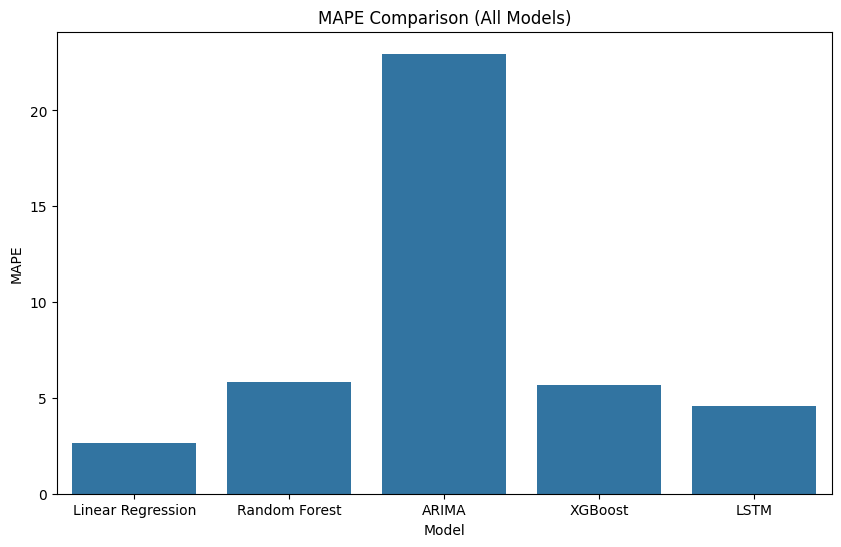

In [84]:
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="MAPE", data=metrics_df)
plt.title("MAPE Comparison (All Models)")
plt.show()

chapter 1 - introduction(15-20 pages) 
    1.1 objective of the project 
    1.2 software and hardware requirements 
    1.3 modules description 
chapter 2 - literature review(4-5 pages) 
chapter 3 - existing system(title name) 
chapter 4 - proposed system(10-15 pages)
    4.1 uml diagrams
    4.2 algorithms used in the project
chapter 5 - implementation and testing
chapter 6 - results & outputs(10-15 pages)
chapter 7 - conclusion
chapter 8 - future scope